## 랜덤포레스트
- uses Majority Voting (for classification)
- uses average (for regression)

In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import model_selection, svm, metrics
from sklearn.model_selection import GridSearchCV

import numpy as np
import pandas as pd

## 결정트리

In [2]:
cancer = load_breast_cancer()
np.random.seed(9)
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, stratify=cancer.target)
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.916083916083916

In [3]:
len(y_train[y_train==1])/len(y_train), len(y_test[y_test==1])/len(y_test)

(0.6267605633802817, 0.6293706293706294)

In [ ]:
print(clf.score(X_test, y_test))

0.916083916083916


In [ ]:
X_train.shape, X_test.shape, cancer.data.shape

((426, 30), (143, 30), (569, 30))

*italicized text*### feature_importances_:
- In trees, it tells how much each feature contributes to decreasing the
  weighted impurity.
- in Random Forest, it averages the decrease in impurity over trees.

In [ ]:
# 결정 트리를 사용한 경우의 중요 변수

list(zip(cancer.feature_names, clf.feature_importances_.round(4)))[:10]

[('mean radius', 0.0),
 ('mean texture', 0.0417),
 ('mean perimeter', 0.0),
 ('mean area', 0.0),
 ('mean smoothness', 0.0),
 ('mean compactness', 0.0),
 ('mean concavity', 0.0),
 ('mean concave points', 0.0426),
 ('mean symmetry', 0.0114),
 ('mean fractal dimension', 0.0)]

In [ ]:
df = pd.DataFrame({'feature':cancer.feature_names,'importance':clf.feature_importances_ })
df=df.sort_values('importance', ascending=False)
print(df.head(10))

                 feature  importance
22       worst perimeter    0.694689
27  worst concave points    0.121068
7    mean concave points    0.042647
1           mean texture    0.041720
21         worst texture    0.039639
13            area error    0.017216
20          worst radius    0.017188
15     compactness error    0.012042
8          mean symmetry    0.011405
14      smoothness error    0.002385


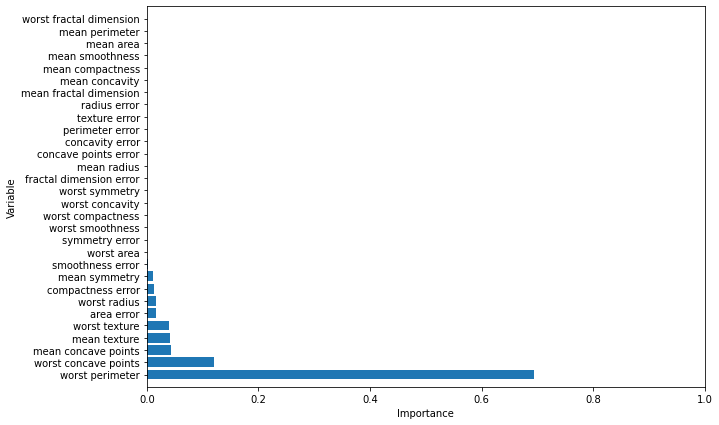

In [ ]:
x = df.feature
y = df.importance
ypos = np.arange(len(x))

plt.figure(figsize=(10,7))
plt.barh(x, y)
plt.yticks(ypos, x)
plt.xlabel('Importance')
plt.ylabel('Variable')
plt.xlim(0, 1)
plt.ylim(-1, len(x))
plt.show()

0.951048951048951


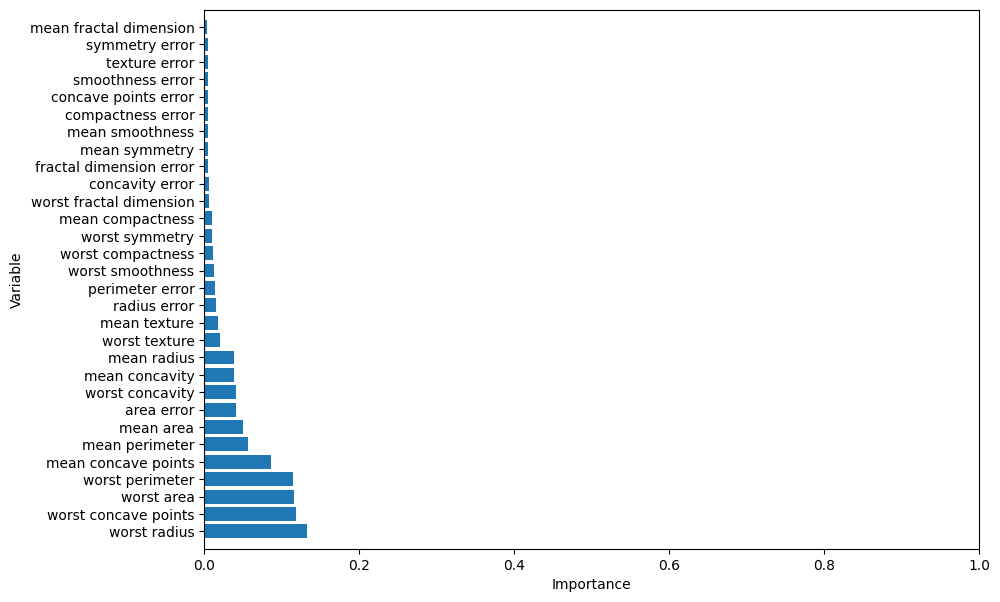

In [4]:
# 랜덤 포레스트를 사용한 경우의 중요 특성

rfc = RandomForestClassifier(n_estimators=500)
rfc.fit(X_train, y_train)
print(rfc.score(X_test, y_test))

df = pd.DataFrame({'feature':cancer.feature_names,'importance':rfc.feature_importances_ })
df=df.sort_values('importance', ascending=False)
x = df.feature
y = df.importance
ypos = np.arange(len(x))

plt.figure(figsize=(10,7))
plt.barh(x, y)
plt.yticks(ypos, x)
plt.xlabel('Importance')
plt.ylabel('Variable')
plt.xlim(0, 1)
plt.ylim(-1, len(x))
plt.show()

- 골고루 사용됨을 알 수 있다.

- ExtraTrees:
  - As in random forests, a random subset of candidate features is used.
  - but instead of looking for the most discriminative thresholds, **thresholds are drawn at random** for each candidate feature and the best of these randomly-generated thresholds is picked as the splitting rule
  - This usually allows to reduce the variance of the model a bit more, at the expense of a slightly greater increase in bias.

0.972027972027972


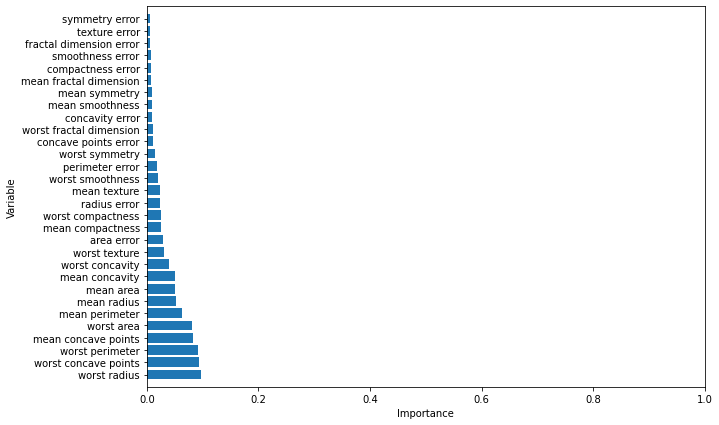

In [ ]:
# ExtraTrees
from sklearn.ensemble import ExtraTreesClassifier
etf = ExtraTreesClassifier(n_estimators=500)
etf.fit(X_train, y_train)
print(etf.score(X_test, y_test))

df = pd.DataFrame({'feature':cancer.feature_names,'importance':etf.feature_importances_ })
df=df.sort_values('importance', ascending=False)
x = df.feature
y = df.importance
ypos = np.arange(len(x))

plt.figure(figsize=(10,7))
plt.barh(x, y)
plt.yticks(ypos, x)
plt.xlabel('Importance')
plt.ylabel('Variable')
plt.xlim(0, 1)
plt.ylim(-1, len(x))
plt.show()

Boosting 방법을 써보자

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(n_estimators=500)
gbc.fit(X_train, y_train)
print(gbc.score(X_test, y_test))

0.9790209790209791


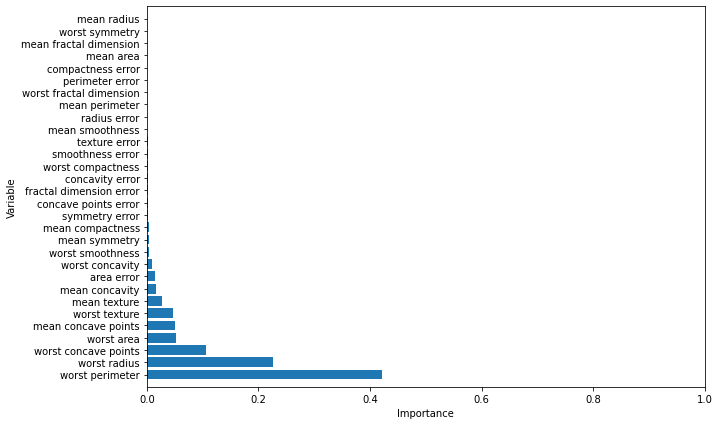

In [ ]:
df = pd.DataFrame({'feature':cancer.feature_names,'importance':gbc.feature_importances_ })
df = df.sort_values('importance', ascending=False)
x = df.feature
y = df.importance
ypos = np.arange(len(x))

plt.figure(figsize=(10,7))
plt.barh(x, y)
plt.yticks(ypos, x)
plt.xlabel('Importance')
plt.ylabel('Variable')
plt.xlim(0, 1)
plt.ylim(-1, len(x))
plt.show()

## Voting Classifier
- combine conceptually different machine learning classifiers and use a majority vote (hard vote) or the average predicted probabilities (soft vote).

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

clf1 = LogisticRegression(max_iter=4000)
clf2 = RandomForestClassifier(n_estimators=50, random_state=1)
clf3 = GaussianNB()

eclf1 = VotingClassifier(
                     estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)],
                     voting='hard')  # str must be unique (seems to be redundant...?)
eclf2 = VotingClassifier(
                     estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)],
                     voting='soft')

for clf, label in zip([clf1, clf2, clf3, eclf1, eclf2],
                      ['Logistic Regression', 'Random Forest', 'naive Bayes', 'Ensemble1', 'Ensemble2']):
     scores = cross_val_score(clf, cancer.data, cancer.target, scoring='accuracy', cv=5)
     print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.95 (+/- 0.02) [Logistic Regression]
Accuracy: 0.96 (+/- 0.02) [Random Forest]
Accuracy: 0.94 (+/- 0.01) [naive Bayes]
Accuracy: 0.95 (+/- 0.02) [Ensemble1]
Accuracy: 0.95 (+/- 0.01) [Ensemble2]


## SVM과 비교

#### Grid Search:
- The grid search will try all combinations of parameter values and select
  the set of parameters which provides the most accurate model.
- 그리드 서치의 매개변수를 설정한다(C, gamma)

In [ ]:
params = [{"C": [1,10,100,1000], "kernel":["linear"]},
          {"C": [1,10,100,1000], "kernel":["rbf"], "gamma":[0.001, 0.0001]}
         ]

clf = GridSearchCV(svm.SVC(), params, n_jobs=-1 )
clf.fit(X_train, y_train)
print('최적값 :', clf.best_estimator_)
print('최적 score :', clf.best_score_)

#테스트 데이터로 최종 평가
score = clf.score(X_test, y_test)
print('최종 평가 =',score)

최적값 : SVC(C=100, kernel='linear')
최적 score : 0.9601094391244871
최종 평가 = 0.965034965034965


# Tuning the hyper-parameters of an estimator
### A search consists of:

- an estimator (regressor or classifier such as sklearn.svm.SVC());
- a parameter space;
- a method for searching or sampling candidates;
- a cross-validation scheme; and
- a score function.

In [ ]:
# to find the names and current values for all parameters for a given
# estimator,
clf.get_params()

{'cv': None,
 'error_score': nan,
 'estimator__C': 1.0,
 'estimator__break_ties': False,
 'estimator__cache_size': 200,
 'estimator__class_weight': None,
 'estimator__coef0': 0.0,
 'estimator__decision_function_shape': 'ovr',
 'estimator__degree': 3,
 'estimator__gamma': 'scale',
 'estimator__kernel': 'rbf',
 'estimator__max_iter': -1,
 'estimator__probability': False,
 'estimator__random_state': None,
 'estimator__shrinking': True,
 'estimator__tol': 0.001,
 'estimator__verbose': False,
 'estimator': SVC(),
 'n_jobs': -1,
 'param_grid': [{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'kernel': ['rbf'], 'gamma': [0.001, 0.0001]}],
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'return_train_score': False,
 'scoring': None,
 'verbose': 0}